# **FIONA HARIA | 60009220048 | D040 | D1-2**

# **Importing Libaries**

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Input,Bidirectional
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV, train_test_split

In [8]:
df = pd.read_csv('/content/amazon_alexa.tsv',delimiter = '\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [9]:
df.shape

(3150, 5)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


# **dropping null values**

In [11]:
df.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [12]:
df[df['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [13]:
df.dropna(inplace=True)

# **cleaning and converting into lower case**

In [14]:
df['verified_reviews'] = df['verified_reviews'].str.lower().str.replace('[^\w\s]', '', regex=True)

# **label encoding the feedback column**

In [15]:
unique_feedback_values = df['feedback'].nunique()
feedback_counts = df['feedback'].value_counts()
print(unique_feedback_values)
print(feedback_counts)

2
feedback
1    2893
0     256
Name: count, dtype: int64


In [16]:
X = df['verified_reviews']
y = df['feedback']

In [17]:
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len)

# **dividing into training and test data**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# **model building**

In [19]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8755 - loss: 0.4424 - val_accuracy: 0.9000 - val_loss: 0.3112
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9271 - loss: 0.2489 - val_accuracy: 0.9032 - val_loss: 0.2790
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9361 - loss: 0.1968 - val_accuracy: 0.9127 - val_loss: 0.2476
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9708 - loss: 0.1210 - val_accuracy: 0.9159 - val_loss: 0.2849
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9774 - loss: 0.0763 - val_accuracy: 0.9095 - val_loss: 0.2548


# **graph plotting**

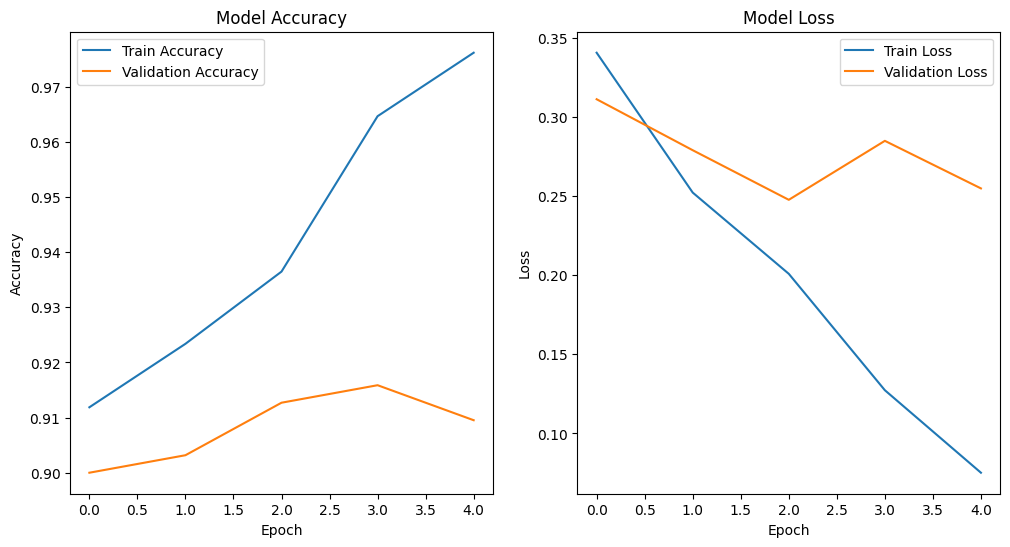

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8996 - loss: 0.2990
Test Accuracy: 90.95%


In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


# **lstm hyper parameter tuning**

In [21]:
!pip install scikeras tensorflow

In [22]:
from scikeras.wrappers import KerasClassifier

In [23]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

In [24]:
def tune_lstm_model(X_train_pad, y_train, X_test_pad, y_test):
    best_accuracy = 0
    best_params = {}

    for lstm_units in [32, 64, 128]:
        for dropout_rate in [0.2, 0.3, 0.4]:
            for learning_rate in [0.001, 0.01]:
                print(f"\nTraining with parameters: LSTM units = {lstm_units}, Dropout rate = {dropout_rate}, Learning rate = {learning_rate}")

                model = Sequential([
                    Embedding(vocab_size, embedding_dim, input_length=max_len),
                    LSTM(lstm_units, return_sequences=True),
                    LSTM(lstm_units // 2),
                    Dense(16, activation='relu'),
                    Dropout(dropout_rate),
                    Dense(1, activation='sigmoid')
                ])

                model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
                model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=0)

                _, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
                print(f"Accuracy with current parameters: {accuracy:.4f}")

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'lstm_units': lstm_units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': learning_rate
                    }

    return best_params, best_accuracy

In [25]:
best_params, best_accuracy = tune_lstm_model(X_train, y_train, X_test, y_test)
print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_accuracy:.4f}")


Training with parameters: LSTM units = 32, Dropout rate = 0.2, Learning rate = 0.001
Accuracy with current parameters: 0.9079

Training with parameters: LSTM units = 32, Dropout rate = 0.2, Learning rate = 0.01
Accuracy with current parameters: 0.9222

Training with parameters: LSTM units = 32, Dropout rate = 0.3, Learning rate = 0.001
Accuracy with current parameters: 0.9048

Training with parameters: LSTM units = 32, Dropout rate = 0.3, Learning rate = 0.01
Accuracy with current parameters: 0.9175

Training with parameters: LSTM units = 32, Dropout rate = 0.4, Learning rate = 0.001
Accuracy with current parameters: 0.9095

Training with parameters: LSTM units = 32, Dropout rate = 0.4, Learning rate = 0.01
Accuracy with current parameters: 0.9127

Training with parameters: LSTM units = 64, Dropout rate = 0.2, Learning rate = 0.001
Accuracy with current parameters: 0.9222

Training with parameters: LSTM units = 64, Dropout rate = 0.2, Learning rate = 0.01
Accuracy with current paramet

# **using textblob and comparing the accuracy with other models**

In [26]:
!pip install textblob
from textblob import TextBlob

def predict_sentiment_textblob(review):
  analysis = TextBlob(review)
  if analysis.sentiment.polarity > 0:
    return 1  # Positive
  else:
    return 0  # Negative

y_pred_textblob = [predict_sentiment_textblob(review) for review in df['verified_reviews'][y_test.index]]

from sklearn.metrics import accuracy_score, classification_report

print("TextBlob Classification Report:")
print(classification_report(y_test, y_pred_textblob))
print("TextBlob Accuracy:", accuracy_score(y_test, y_pred_textblob))

y_pred_lstm = (model.predict(X_test) > 0.5).astype("int32")

print("\nLSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm))
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))



TextBlob Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.57      0.36        63
           1       0.95      0.82      0.88       567

    accuracy                           0.80       630
   macro avg       0.60      0.70      0.62       630
weighted avg       0.88      0.80      0.83       630

TextBlob Accuracy: 0.7968253968253968
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.38      0.46        63
           1       0.93      0.97      0.95       567

    accuracy                           0.91       630
   macro avg       0.75      0.67      0.70       630
weighted avg       0.90      0.91      0.90       630

LSTM Accuracy: 0.9095238095238095


# **comparison charts**

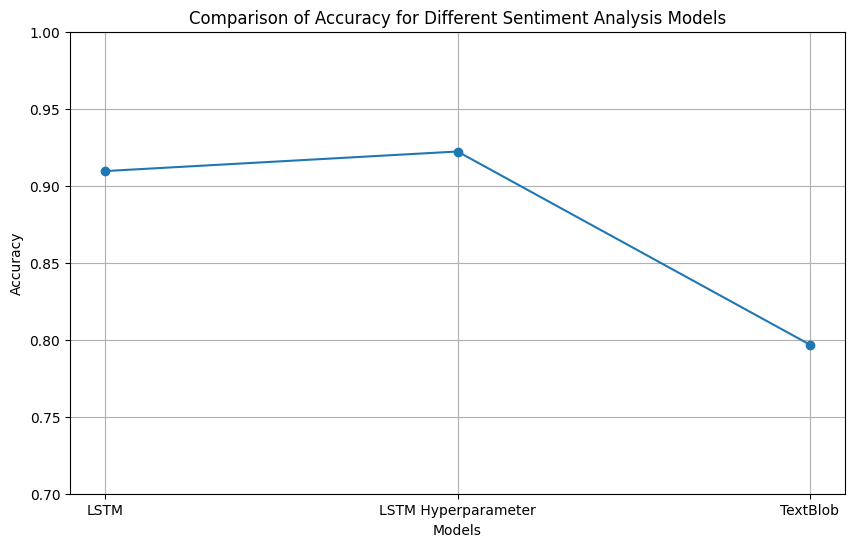

In [28]:

lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
lstm_hyperparameter_accuracy = best_accuracy
textblob_accuracy = accuracy_score(y_test, y_pred_textblob)

model_names = ['LSTM', 'LSTM Hyperparameter', 'TextBlob']
accuracies = [lstm_accuracy, lstm_hyperparameter_accuracy, textblob_accuracy]

plt.figure(figsize=(10, 6))
plt.plot(model_names, accuracies, marker='o')
plt.title('Comparison of Accuracy for Different Sentiment Analysis Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.grid(True)
plt.show()
